# Radial Basis Function Neural Networks

**Ruby Nunez**

Train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9).

In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})
np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and preprocess data

- Loads the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separates the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalizes each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Uses the `min` and `max` values derived from the training set to normalize the test set.

In [11]:
import pandas as pd
import numpy as np

# Normalize data
def normalize_data(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

# Load and preprocess data
def load_and_preprocess_data(train_file, test_file):
    print("train_file type", type(train_file))

    if isinstance(train_file, str) and isinstance(test_file, str):
        train_data = pd.read_csv(train_file)
        test_data = pd.read_csv(test_file)
        print("train_file shape", train_data.shape)

        X_train = train_data.iloc[:, :-1]
        y_train = train_data.iloc[:, -1]
        X_test = test_data.iloc[:, :-1]
        y_test = test_data.iloc[:, -1]
    else:
        X_train = train_file[:, :-1]
        print(X_train.shape)
        y_train = train_file[:, -1]
        X_test = test_file[:, :-1]
        y_test = test_file[:, -1]

    min_val = X_train.min()
    max_val = X_train.max()
    X_train_normalized = normalize_data(X_train, min_val, max_val)
    X_test_normalized = normalize_data(X_test, min_val, max_val)

    X_train_normalized = np.array(X_train_normalized)
    y_train = np.array(y_train)
    X_test_normalized = np.array(X_test_normalized)
    y_test = np.array(y_test)

    return X_train_normalized, y_train, X_test_normalized, y_test

train_file = 'data/rbf_dev_train.csv'
test_file = 'data/rbf_dev_test.csv'

rbf_dev_train, y_train, rbf_dev_test, y_test = load_and_preprocess_data(train_file, test_file)

train_file type <class 'str'>
train_file shape (1600, 3)


### Plot data

Creates a scatter plot of the training data in the cell below.

- Color codes each sample by its output class.
- Makes the aspect ratio (height and width) of the x and y axes in the figure equal to avoid distorted plot.

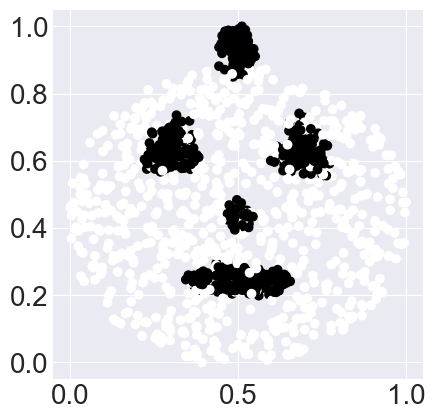

In [12]:
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)
plt.gca().set_aspect('equal')
plt.show()

## Radial basis function neural network

In [14]:
from rbf_net import RBF_Net

### Network initalization

Using K-means to initialize the RBF hidden layer prototypes and sigmas.

Implements methods in `rbf.py` that initialize the hidden layer of the neural network:
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Computes the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Uses K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [15]:
from k_means import KMeans

#### Test initialization methods

Test code for RBF network initialization:
- Creates a new RBF network with 7 hidden units and 2 output classes.
- Calls `initalize` method on it, passing in the training data.
- Creates a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

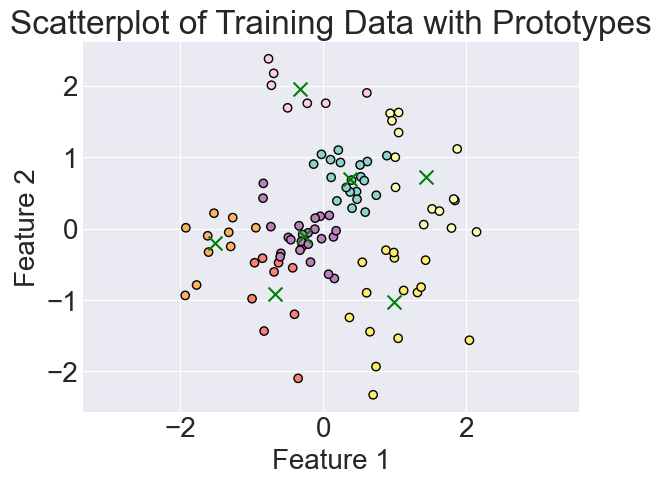

In [17]:
X = np.random.normal(size=(100, 2))
centroids = np.random.normal(size=(7, 2))
assignments = np.random.randint(low=0, high=7, size=(100,))

kmeansObj = KMeans(test_data)

rbf_net = RBF_Net(7, 2)

clust_mean_dists = rbf_net.avg_cluster_dist(X, centroids, assignments, kmeansObj)

rbf_net.initialize(X)

plt.scatter(X[:, 0], X[:, 1], c=rbf_net.cluster_assignments, cmap='Set3_r', edgecolors='k')
plt.scatter(rbf_net.prototypes[:, 0], rbf_net.prototypes[:, 1], c='green', marker='x', s=100)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatterplot of Training Data with Prototypes')
plt.axis('equal')
plt.show()

### Compute hidden and output layer activations

Implements the following methods to train the RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [19]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Hidden layer activation is\n{test_h_act}')

Hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


### Network weights using linear regression

To train RBF network, finds optimal weights between hidden and output layer neurons to allow the network to accurately classify the training data. 

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

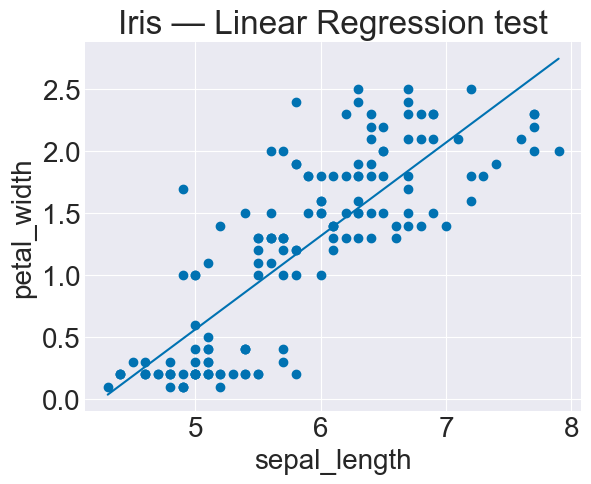

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### Train RBF Network

From `rbf_net.py`, implements the following methods to train neural network. Trains a RBF network with 10 hidden units on the RBF dev dataset.

- `train`: Determines the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Uses trained network (after learning) to predict the class of data.
- `accuracy`: Computes the accuracy by comparing the network predicted and actual class for each data sample.



In [21]:
train_file = 'data/rbf_dev_train.csv'
test_file = 'data/rbf_dev_test.csv'

rbf_dev_train, y_train, rbf_dev_test, y_test = load_and_preprocess_data(train_file, test_file)

num_features = rbf_dev_train.shape[1]

centroids = np.random.normal(size=(10, num_features))

num_hidden_units = 10
num_classes = np.unique(y_train).size

num_data_points = rbf_dev_train.shape[0]
assignments = np.random.randint(low=0, high=10, size=(num_data_points,))

rbf_net = RBF_Net(num_hidden_units, num_classes)

clust_mean_dists = rbf_net.avg_cluster_dist(rbf_dev_train, centroids, assignments, kmeansObj)

rbf_net.initialize(rbf_dev_train)

rbf_net.train(rbf_dev_train, y_train)

train_file type <class 'str'>
train_file shape (1600, 3)


In [46]:
# Training set accuracy
y_train_pred = rbf_net.predict(rbf_dev_train)
train_set_accuracy = rbf_net.accuracy(y_train, y_train_pred)
print("Training Set Accuracy:", train_set_accuracy)

Training Set Accuracy: 0.886875


In [47]:
# Test set accuracy
y_test_pred = rbf_net.predict(rbf_dev_test)
test_set_accuracy = rbf_net.accuracy(y_test, y_test_pred)
print("Testing Set Accuracy:", test_set_accuracy)

Testing Set Accuracy: 0.895


## Handwritten digit classification: MNIST data

Trains a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

Training network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### Load in MNIST dataset

- Numpy function `load` the MNIST train/test data and the associated class labels.
- Creates a 5x5 grid showing the first 25 images in the dataset.

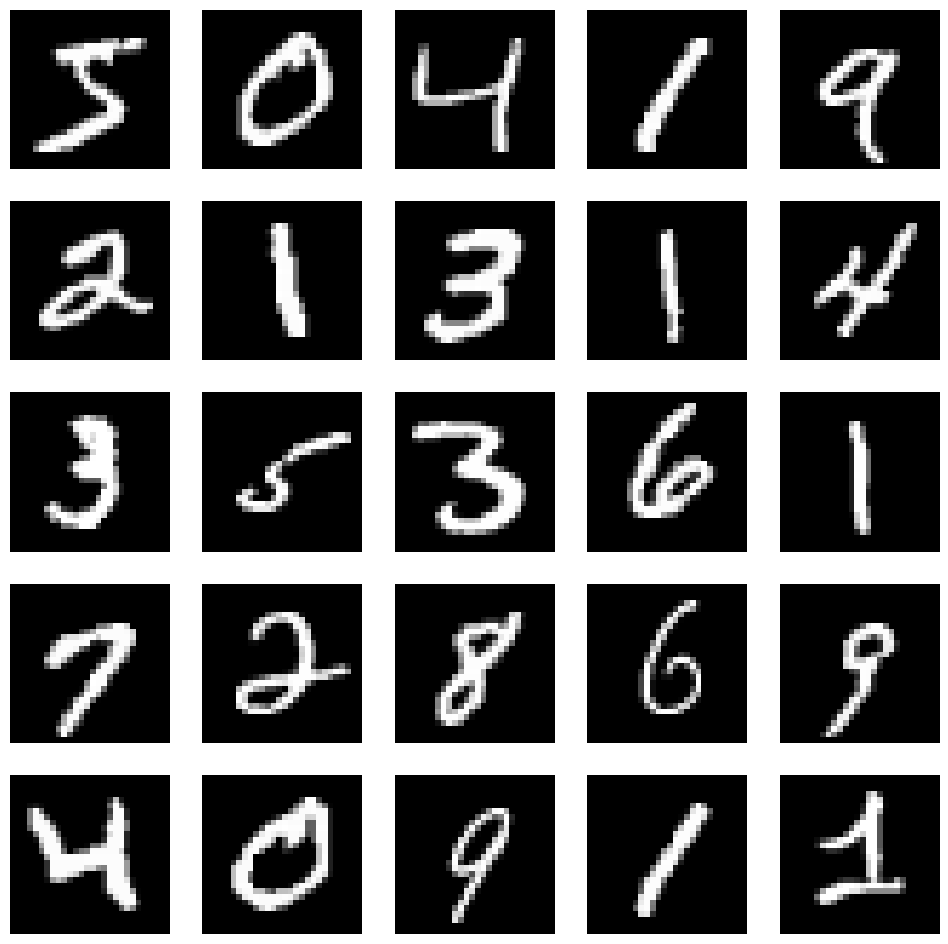

In [85]:
x_train_mnist = np.load('data/mnist_train_data.npy')
y_train_mnist = np.load('data/mnist_train_labels.npy')
x_test_mnist = np.load('data/mnist_test_data.npy')
y_test_mnist = np.load('data/mnist_test_labels.npy')

fig, axs = plt.subplots(5, 5, figsize=(12, 12))

axs = axs.reshape(-1)

for i in range(25):
    ax = axs[i]
    ax.imshow(x_train_mnist[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.show()

### Preprocess data

- Flattens non-leading dimensions of the train and test sets. For example, the training set goes from (60000, 28, 28) to (60000, 784).
- Normalizes data so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [125]:
def flatten_data(data):
    if len(data.shape) > 2:
        return data.reshape(data.shape[0], -1)
    return data

x_train_flattened = flatten_data(x_train_mnist)
x_test_flattened = flatten_data(x_test_mnist)


x_train_normalized = normalize_data(x_train_flattened, np.min(x_train_flattened), np.max(x_train_flattened))
x_test_normalized = normalize_data(x_test_flattened, np.min(x_train_flattened), np.max(x_train_flattened))

print("x_train_mnist.shape", x_train_normalized.shape)
print("y_train_mnist.shape", y_train_mnist.shape)
print("x_test_mnist.shape", x_test_normalized.shape)
print("y_test_mnist.shape", y_test_mnist.shape)

x_train_mnist.shape (60000, 784)
y_train_mnist.shape (60000,)
x_test_mnist.shape (60000, 784)
y_test_mnist.shape (10000,)


### Train and assess performance on MNIST

Train a RBF network on MNIST.

In [258]:
import numpy as np
subset = 1500
x_train_subset = x_train_normalized[:subset]
y_train_subset = y_train_mnist[:subset]
num_hidden_units = 25
num_features = x_train_subset.shape[1]
centroids = np.random.normal(size=(num_hidden_units, num_features))
num_classes = np.unique(y_train_subset).size

num_data_points = x_train_subset.shape[0]
assignments = np.random.randint(low=0, high=num_hidden_units, size=(num_data_points,))

mnist_net = RBF_Net(num_hidden_units, num_classes)

clust_mean_dists = mnist_net.avg_cluster_dist(x_train_subset, centroids, assignments, kmeansObj)

mnist_net.initialize(x_train_subset)

mnist_net.train(x_train_subset, y_train_subset)

In [259]:
# train acc
y_train_pred = mnist_net.predict(x_train_subset)
train_set_accuracy = mnist_net.accuracy(y_train_subset, y_train_pred)
print("Training Set Accuracy:", train_set_accuracy)

Training Set Accuracy: 0.814


In [260]:
# test acc
y_test_pred = mnist_net.predict(x_test_normalized)
test_set_accuracy = mnist_net.accuracy(y_test_mnist, y_test_pred)
print("Testing Set Accuracy:", test_set_accuracy)

Testing Set Accuracy: 0.7879


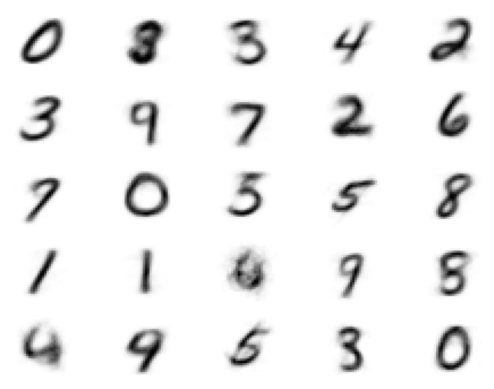

In [261]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])